In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt

# set the random number generator
np.random.seed(42)

In [19]:
import csv
import string
import pathlib
import gzip

# Load Data and Inspect
The data is in `./websplit` folder.  

In [3]:
raw_sentences = []  # empty list to store sentences
with open("websplit/test.tsv", "r") as f:
    reader = csv.reader(f, delimiter='\t')  # read a tsv file
    for row in reader:
        # print("Original Sentence:", row[0])      # Uncomment to view data
        # print("Split sentences", row[1].split("<::::>"))
        # print("\n")
        
        raw_sentences.extend(row[1].split("<::::>"))
print("Total Sentences: ", len(raw_sentences))

Total Sentences:  10000


In [4]:
# Some samples
print(raw_sentences[99], '\n', raw_sentences[100])

 He was was arrested and booked on charges of first - degree murder and first - degree robbery . 
 A 2006 estimate by the International Organization for Migration put the number of Sudanese people in the UK at a much higher figure . 


In [5]:
# As we see there are lots of punctuations which we dont have in EMNIST, so we are going to remove them, 
# and replace multiple spaces with one
import re

sentences = []
table = str.maketrans({key: None for key in string.punctuation})  # translation table

for sentence in raw_sentences:
    # remove punctuation and non-ascii characters
    clean_sentence = re.sub('  +', ' ', sentence.translate(table)).\
                        encode("ascii", 'ignore').decode()  
    sentences.append(clean_sentence.strip())  # add to clean sentences
    
print(sentences[99], '\n', raw_sentences[99])  # to verify

He was was arrested and booked on charges of first degree murder and first degree robbery 
  He was was arrested and booked on charges of first - degree murder and first - degree robbery .


# Make Images for Sentences

### First step is to load the EMIST data and the mapping table

In [7]:
import sys
sys.path.append('../')  # so that we can import libs from other chapters and utils

from utils import emnist_utils

In [8]:
######## GPU CONFIGS FOR RTX 2070 ###########
## Please ignore if not training on GPU ##
from tensorflow.keras import backend as K
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True  # dont allocate all memory at once
config.gpu_options.allocator_type = 'BFC'  #A "Best-fit with coalescing" algorithm, simplified from a version of dlmalloc
config.gpu_options.per_process_gpu_memory_fraction = 2.0  # Use host memory as swap space, may not work on all architectures
config.log_device_placement=True
session = InteractiveSession(config=config)
K.set_session(session)
##########################################

In [11]:
# Load train and test data from Chapter 1 location
train = {}
test = {}

train['features'], train['labels'] = emnist_utils.read_emnist('../Chapter1/data/emnist-bymerge-train-images-idx3-ubyte.gz', '../Chapter1/data/emnist-bymerge-train-labels-idx1-ubyte.gz')
test['features'], test['labels'] = emnist_utils.read_emnist('../Chapter1/data/emnist-bymerge-test-images-idx3-ubyte.gz', '../Chapter1/data/emnist-bymerge-test-labels-idx1-ubyte.gz')

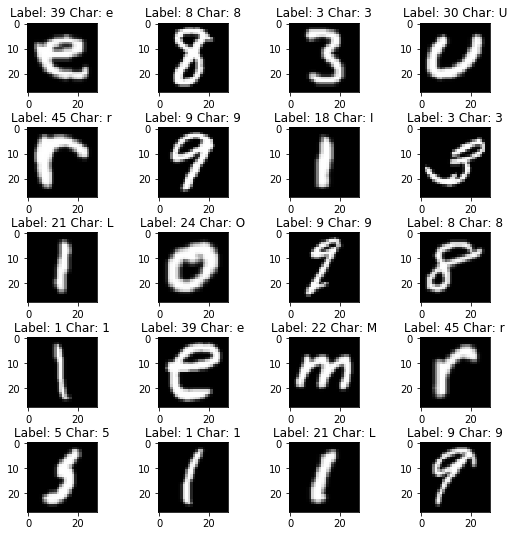

In [12]:
mappings = emnist_utils.map_emnist_labels("../Chapter1/data/emnist-bymerge-mapping.txt")
# Plot some images to verify we got the data right
emnist_utils.display_emnist_images(test['features'], test['labels'], mappings)

In [13]:
# To help in converting a list of characters into a sequence of images, 
# we need a list of image IDs corresponding to the same character
# or number. So, a reverse index needs to be generated
image_index = {}  # where key is the char and value is a list of IDs
for idx, code in enumerate(train['labels'].tolist()):
    char = mappings[code]
    if char in image_index:
        # this character already exists
        image_index[char].append(idx)  # append index
    else:
        image_index[char] = [idx]  # initiate list with 1 item

### Second step is to load sentence at a time, create set of images that can be joined with each other to produce the sentence.

In [15]:
def get_sample_sentences(sentences_in=sentences, num_sentence=10):
    # Get a defined number of sentences from the data
    return np.random.choice(sentences_in, num_sentence)

def get_generated_image(words, chars=train['features'], index=image_index):
    # words is string of char/numbers that needs to be converted into an image
    # chars is a data set of images that need to be used to compose, usually pass in train['features'] in here
    # index maps a character to indexes in the images, available as dictionary
    height, width = train['features'][0].shape # height and width of each character
    length = len(words) # total number of characters in the image
    
    # create an empty array to store the data
    image = np.zeros((height, width * length))
    pos = 0  # starting index of the character
    
    for char in words:
        if char is ' ':
            pos += width # if space, move over
        else:
            if char in image_index:
                # pick a random item from all images for that char
                idx = np.random.choice(image_index[char])  
                image[:, pos:(pos+width)] += chars[idx]
            elif char.upper() in image_index:  # to remove characters from other languages
                # for some characters, there is only upper case
                idx = np.random.choice(image_index[char.upper()])  
                image[:, pos:(pos+width)] += chars[idx]
            
            pos += width
    
    return image

['His father abandoned the family when he was only 8 years old']


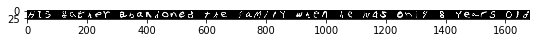

In [16]:
# Let's print a sample to see how it looks
s = get_sample_sentences(sentences, 1)
print(s)
img = get_generated_image(s[0])
plt.figure(figsize=(9,2))
plt.imshow(img, cmap='gray')
plt.show()

### Third step is to generate a number of sentences for training and testing and save them to disk for processing

In [271]:
train_sentences = sentences[:9000]
test_sentences = sentences[9000:]

# Lets assume that for each training sample, 2 variants will be generated

def generate_sentences(texts, chars, 
                           index, num_variants=2, max_length=32):
    # this method takes input text lines, character samples and labels
    # and generates images. It can generate multiple images per sentence
    # as controlled by num_variants parameter. max_length parameter
    # ensures that all sentences are the same length
    
    # total number of samples to generate
    num_samples = len(texts) * num_variants
    height, width = chars[0].shape  # shape of image
    
    # setup empty array of the images
    images = np.zeros((num_samples, height, width * max_length), np.float64)
    labels = []
    
    for i, item in enumerate(texts):
        padded_item = item[0:max_length] if (len(item) > max_length) else item.ljust(max_length, ' ')
        
        for v in range(num_variants):
            img = get_generated_image(padded_item, chars, index)
            images[i*num_variants+v, :, :] += img
            labels.append(padded_item)
    
    return images, labels

In [275]:
train_images, train_labels = generate_sentences(train_sentences, train['features'], image_index)
test_images, test_labels = generate_sentences(test_sentences, train['features'], image_index)

In [278]:
# Now to save these models for easy loading
pp = pathlib.Path('.') / 'sentences'
pp.mkdir(exist_ok=True)  # create the directory

np.save(pp / 'train_images', train_images)
np.save(pp / 'test_images', test_images)
np.save(pp / 'train_labels', train_labels)
np.save(pp / 'test_labels', test_labels)

In [ ]:
# free up space
del raw_sentences, train, test

# Building the Model to Recognize Sentences

In [25]:
# Lets load the zipped Numpy files from disk and hydrate the training and test data
pp = pathlib.Path('.') / 'sentences'

# training labels and images
file = gzip.GzipFile(pp / 'train_labels.npy.gz', 'r')
train_labels = np.load(file)
file = gzip.GzipFile(pp / 'train_images.npy.gz', 'r')
train_images = np.load(file)

# test labels and images
file = gzip.GzipFile(pp / 'test_labels.npy.gz', 'r')
test_labels = np.load(file)
file = gzip.GzipFile(pp / 'test_images.npy.gz', 'r')
test_images = np.load(file)

Bandolier Budgie a free iTunes a


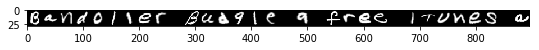

In [28]:
# Sample some to check
print(train_labels[1])
plt.figure(figsize=(9,2))
plt.imshow(train_images[1], cmap='gray')
plt.show()

In [33]:
train_images.shape

(18000, 28, 896)

In [52]:
# CNN definition : LeNet5 architecture, a classic architecture
# Based on paper: http://vision.stanford.edu/cs598_spring07/papers/Lecun98.pdf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten
from tensorflow.keras.layers import Dense, Input, Reshape, Lambda,  TimeDistributed


image_height, image_width = train_images[1].shape
output_length = 32  # we limited output sentences to 32 chars
num_classes = 47  # That is the emnist dimensions

# Since each image is a sentence, we will extract patches from it
# width of each patch will be 20 pixels wide (note EMNIST is 28 px)
# and every time we will move 14 px over to extract another sample
# This may result in same char be detected multople times but that is ok
patch_width = 20
patch_stride = 14

# construct the patches
image_input = Input(shape=(image_height, image_width))

# reshape to add dimensions
image_reshaped = Reshape((image_height, image_width, 1))(image_input)

def extract_patches(image):
    kernel = [1, 1, patch_width, 1]
    strides = [1, 1, patch_stride, 1]
    patches = tf.image.extract_image_patches(image, kernel, strides, [1, 1, 1, 1], 'VALID')
    print(patches)
    # output of previous is [None, 28, 63, 20]. should be [none, 63, 28, 20]
    patches = tf.transpose(patches, (0, 2, 1, 3))  # why transpose?
    print(patches)
    patches = tf.expand_dims(patches, -1)
    print(patches)
    return patches
    
image_patches = Lambda(extract_patches)(image_reshaped)

leNet = Sequential()
leNet.add(Conv2D(32, kernel_size=(3, 3), activation='relu', 
                 input_shape=(image_height, image_width, 1)))
leNet.add(Conv2D(64, (3, 3), activation='relu'))
leNet.add(MaxPooling2D(pool_size=(2, 2)))
leNet.add(Dropout(0.2))
leNet.add(Flatten())
# Note the last drop out and activation layers are removed
# because the out put of this network feeds another network

leNet_out = Model(inputs=leNet.inputs, outputs=leNet.output)
leNet_out.summary()

# (num_windows, 128)
leNet_out = TimeDistributed(leNet_out)(image_patches)

print(leNet_out)

Tensor("lambda_14/ExtractImagePatches:0", shape=(None, 28, 63, 20), dtype=float32)
Tensor("lambda_14/transpose:0", shape=(None, 63, 28, 20), dtype=float32)
Tensor("lambda_14/ExpandDims:0", shape=(None, 63, 28, 20, 1), dtype=float32)
Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26_input (InputLayer) [(None, 28, 896, 1)]      0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 26, 894, 32)       320       
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 24, 892, 64)       18496     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 12, 446, 64)       0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 12, 446, 64)       0         
_______________________

In [ ]:
# Now, lets buid the LSTM model
keras.layers import  Permute, RepeatVector, LSTM, GRU, Bidirectional

lstm_out = LSTM(128, return_sequences=True)(leNet_out)
# (num_windows, 128)

softmax_output = Dense(num_classes, activation='softmax', name='softmax_output')(lstm_out)

In [68]:
mappings[47] = ' '  # add a space for spacing words
inverse_mappings = {v: k for k, v in mappings.items()}
inverse_mappings


{'0': 0,
 '1': 1,
 '2': 2,
 '3': 3,
 '4': 4,
 '5': 5,
 '6': 6,
 '7': 7,
 '8': 8,
 '9': 9,
 'A': 10,
 'B': 11,
 'C': 12,
 'D': 13,
 'E': 14,
 'F': 15,
 'G': 16,
 'H': 17,
 'I': 18,
 'J': 19,
 'K': 20,
 'L': 21,
 'M': 22,
 'N': 23,
 'O': 24,
 'P': 25,
 'Q': 26,
 'R': 27,
 'S': 28,
 'T': 29,
 'U': 30,
 'V': 31,
 'W': 32,
 'X': 33,
 'Y': 34,
 'Z': 35,
 'a': 36,
 'b': 37,
 'd': 38,
 'e': 39,
 'f': 40,
 'g': 41,
 'h': 42,
 'n': 43,
 'q': 44,
 'r': 45,
 't': 46,
 ' ': 47}

In [74]:
# now convert categorical labels from the sentences
encode = lambda x: [inverse_mappings[xi] if xi in inverse_mappings else inverse_mappings[xi.upper()] for xi in x]
decode = lambda x: [mappings[xi] for xi in x]

train_labels_cat = np.array([encode(xi) for xi in train_labels])
test_labels_cat = np.array([encode(xi) for xi in test_labels])

# Verify the encoding/decoding
print(train_labels[1])
print(train_labels_cat.shape, train_labels_cat[1])
print(decode(train_labels_cat[1]))

Bandolier Budgie a free iTunes a
(18000, 32) [11 36 43 38 24 21 18 39 45 47 11 30 38 41 18 39 47 36 47 40 45 39 39 47
 18 29 30 43 39 28 47 36]
['B', 'a', 'n', 'd', 'O', 'L', 'I', 'e', 'r', ' ', 'B', 'U', 'd', 'g', 'I', 'e', ' ', 'a', ' ', 'f', 'r', 'e', 'e', ' ', 'I', 'T', 'U', 'n', 'e', 'S', ' ', 'a']


In [73]:
print(decode(train_labels_cat[1]))

['B', 'a', 'n', 'd', 'O', 'L', 'I', 'e', 'r', ' ', 'B', 'U', 'd', 'g', 'I', 'e', ' ', 'a', ' ', 'f', 'r', 'e', 'e', ' ', 'I', 'T', 'U', 'n', 'e', 'S', ' ', 'a']


In [31]:

from notebook.services.config import ConfigManager
ip = get_ipython()
cm = ConfigManager(parent=ip)
cm.update('notebook', {"ruler_column": [80]})

{'Cell': {'cm_config': {'lineNumbers': True}},
 'load_extensions': {'jupyter-js-widgets/extension': True},
 'ruler_column': [80]}